In [43]:
import math, time 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
start = time.time()
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix


In [26]:
mnist_dataset = fetch_openml('mnist_784', version=1, as_frame=True)
# mnist_dataframe = pd.read_csv('/Users/shriramr/OneDrive - University at Buffalo/First Semester/Pattern Recognition/Demo Code/Extras/mnist_train_small.csv', sep=',', index_col=0)
#print mnist_dataframe.head(3)
# print(mnist_dataframe.shape)

In [27]:
mnist_dataframe = pd.DataFrame(data= np.c_[mnist_dataset['data'], mnist_dataset['target']],
                     columns= mnist_dataset['feature_names'] + ['target'])

In [28]:
print(mnist_dataframe.shape)

(70000, 785)


/Users/shriramr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


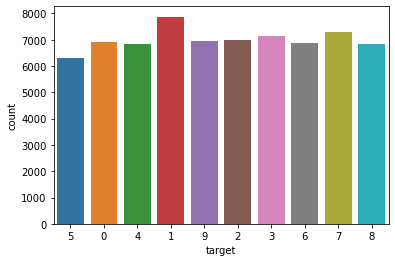

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: target, dtype: int64


In [30]:
sns.countplot(mnist_dataframe['target'])
plt.show()# looks kinda okay
# or we can just print
print(mnist_dataframe['target'].value_counts())

In [31]:
X_tr = mnist_dataframe.iloc[:,:-1] # iloc ensures X_tr will be a dataframe
y_tr = mnist_dataframe.iloc[:, -1]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_tr,y_tr,test_size=0.2, random_state=30, stratify=y_tr)

In [40]:
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]}
pipeline = Pipeline(steps) # define Pipeline object

In [44]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

In [ ]:
print("Score = %3.2f"%(grid.score(X_test, y_test)))

In [ ]:
print("best parameters from train data: ", grid.best_params_)

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
for i in (np.random.randint(0,270,6)):
	two_d = (np.reshape(X_test.values[i], (28, 28)) * 255).astype(np.uint8)
	plt.title('predicted label: {0}'. format(y_pred[i]))
	plt.imshow(two_d, interpolation='nearest', cmap='gray')
	plt.show()

In [ ]:
print("confusion matrix: \n ", confusion_matrix(y_test, y_pred))